# Advanced: RV Estimators

## Setup

Let's first make sure we have the latest version of PHOEBE 2.4 installed (uncomment this line if running in an online notebook session such as colab).

In [1]:
#!pip install -I "phoebe>=2.4,<2.5"

In [2]:
import phoebe
from phoebe import u # units
import numpy as np

logger = phoebe.logger()

## Generate data

Let's first initialize a bundle and change some of the parameter values. We'll then export the computed models as "observables" to use with the rv_geometry estimator.

In [3]:
b = phoebe.default_binary()
# set parameter values
b.set_value('q', value = 0.6)
b.set_value('incl', component='binary', value = 84.5)
b.set_value('ecc', 0.2)
b.set_value('per0', 63.7)
b.set_value('sma', component='binary', value= 7.3)
b.set_value('vgamma', value= -32.84)

# add an rv dataset
b.add_dataset('rv', compute_phases=phoebe.linspace(0,1,101))

#compute the model
b.run_compute()

# extract the arrays from the model that we'll use as observables in the next step and add noise to the rvs
times = b.get_value('times', context='model', component='primary', dataset='rv01')
np.random.seed(0) # to ensure reproducibility with added noise
rvs1 = b.get_value('rvs', component='primary', context='model', dataset='rv01') + np.random.normal(size=times.shape)
rvs2 = b.get_value('rvs', component='secondary', context='model', dataset='rv01') + np.random.normal(size=times.shape)
sigmas_rv = np.ones_like(times) * 2

100%|████████████████████████████████████████| 101/101 [07:48<00:00,  4.64s/it]


## Initialize the bundle

To showcase the rv_estimator, we'll start with a fresh default bundle.

100%|████████████████████████████████████████| 101/101 [00:05<00:00, 18.26it/s]
/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


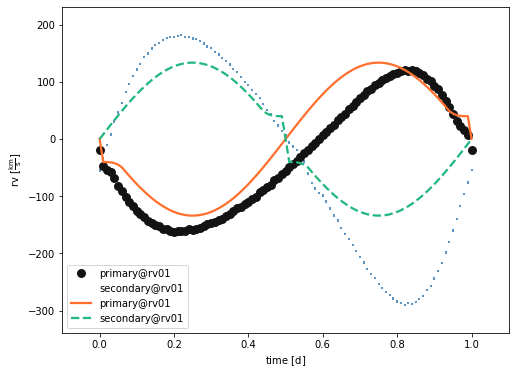

In [4]:
b = phoebe.default_binary()
b.add_dataset('rv')
b.set_value_all('times', dataset='rv01', value = times)
b.set_value('rvs', component='primary', dataset='rv01', value = rvs1)
b.set_value('rvs', component='secondary', dataset='rv01', value = rvs2)
b.set_value_all('sigmas', dataset='rv01', value = sigmas_rv)

b.run_compute()
_ = b.plot(legend=True, show=True)

## rv_geometry

The [rv_geometry estimator](../api/phoebe.parameters.solver.estimator.rv_geometry.md) is meant to provide an efficient starting point for q, vgamma, asini, esinw and ecosw. Similar to the [light curve estimators](./LC_estimators.ipynb), it will by default bin the input data if the number of data points is larger than `phase_nbins` and will expose the analytical (in this case, Keplerian orbit) models that were fit to the data.First we add the solver options via [add_solver](../api/phoebe.frontend.bundle.Bundle.add_solver.md):

In [5]:
b.add_solver('estimator.rv_geometry', solver='rvgeom')
print(b.filter(solver='rvgeom'))

ParameterSet: 7 parameters
           comments@rvgeom@solver: 
         use_server@rvgeom@solver: none
        rv_datasets@rvgeom@solver: ['*']
              orbit@rvgeom@solver: binary
          phase_bin@rvgeom@solver: True
        phase_nbins@rvgeom@solver: 500
       expose_model@rvgeom@solver: True


In [6]:
b.run_solver('rvgeom', solution='rvgeom_solution')
print(b.filter(solution='rvgeom_solution'))

ParameterSet: 17 parameters
R  orbit@rvgeom_solution@solution: binary
R  input_phases@primary@rvgeom...: [-0.49 -0.48 -0.47 ...
  0.48  0.49  0.5 ]
R  input_rvs@primary@rvgeom_so...: [-49.11745225 -43.99285763
 -38.56435814 ... -68.6381972
 -61.48676441 -56.33170441] km / s
R  input_sigmas@primary@rvgeom...: [2. 2. 2. ... 2. 2. 2.] km / s
R  analytic_rvs@primary@rvgeom...: [-54.63337611 -51.60264538
 -48.55302746 ...
 -60.63542497 -57.64453117
 -54.63337611] km / s
R  input_phases@secondary@rvge...: [-0.49 -0.48 -0.47 ...
  0.48  0.49  0.5 ]
R  input_rvs@secondary@rvgeom_...: [ -5.78739805 -13.15231
 -18.66501765 ...
  23.64803231  14.47138099
   6.51675494] km / s
R  input_sigmas@secondary@rvge...: [2. 2. 2. ... 2. 2. 2.] km / s
R  analytic_rvs@secondary@rvge...: [ 3.52283223 -1.5088635
 -6.57191623 ...
 13.48758539  8.52202795
  3.52283223] km / s
R  analytic_phases@rvgeom_solu...: [-0.5   -0.495 -0.49  ...  0.49
  0.495  0.5  ]
R  fitted_twigs@rvgeom_solutio...: ['t0_supconj@binary@

The solution, as expected returns the fitted values and the analytic models we fit to get them, which can be turned off by setting `expose_model` to False. Let's inspect the fitted twigs and values before adopting the solution:

In [7]:
print(b.get_value('fitted_twigs', solution='rvgeom_solution'))
print(b.get_value('fitted_values', solution='rvgeom_solution'))

['t0_supconj@binary@orbit@component' 'q@binary@orbit@component'
 'asini@binary@orbit@component' 'ecc@binary@orbit@component'
 'per0@binary@orbit@component' 'vgamma@system']
[0.006207003320612168 0.5986624294643009 5100827.374345278
 0.19183504180758906 1.2013560347738608 -32.77199126050141]


As we can see all values look okay, and we have *asini@binary* in the twigs, which means we'll need to flip the *asini* constraint to be able to set it with [adopt_solution](../api/phoebe.frontend.bundle.Bundle.adopt_solution.md):

Sun, 29 May 2022 09:58 BUNDLE       WARNING overwriting model: latest
100%|████████████████████████████████████████| 101/101 [07:13<00:00,  4.29s/it]
/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


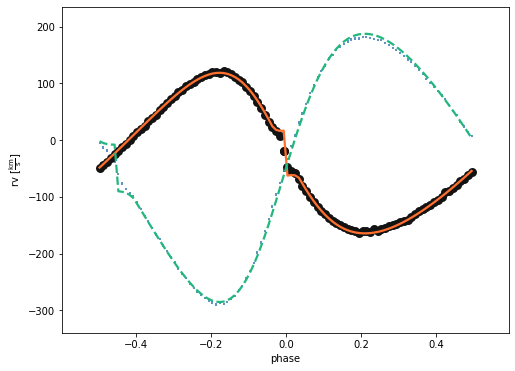

In [8]:
b.flip_constraint('asini@binary', solve_for='sma@binary')
b.adopt_solution('rvgeom_solution')

b.run_compute()
_ = b.plot(x='phases', show=True)

## single-lined RVs

In some cases, only one RV is available, in which case not all parameters can be estimated with rv_geometry. Let's recreate the above example with only providing the primary RV and see how the solution differs.

100%|████████████████████████████████████████| 101/101 [00:05<00:00, 18.19it/s]


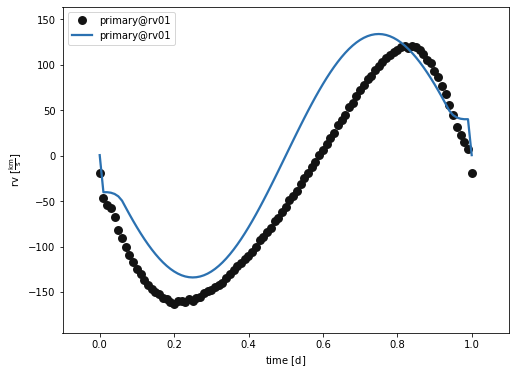

In [9]:
b = phoebe.default_binary()
b.add_dataset('rv', component='primary', times=times, rvs = rvs1, sigmas=sigmas_rv)

b.run_compute()
_ = b.plot(legend=True, show=True)

In [10]:
b.add_solver('estimator.rv_geometry', solver='rvgeom')
b.run_solver('rvgeom', solution='rvgeom_solution')

<ParameterSet: 17 parameters | components: primary, secondary>

In [11]:
print(b.get_value('fitted_twigs', solution='rvgeom_solution'))
print(b.get_value('fitted_values', solution='rvgeom_solution'))

['t0_supconj@binary@orbit@component' 'asini@primary@star@component'
 'ecc@binary@orbit@component' 'per0@binary@orbit@component'
 'vgamma@system']
[0.0 1913401.2113919184 0.20212943071520692 1.1076745200333622
 -20.48179315718763]


If we compare the *fitted_twigs* from this solution with our two-RV solution, we'll notice two things:
- *q* is missing from the list
- We have *asini@primary* instead of *asini@binary*.
This is because with only one RV we cannot get a reliable estimate of the mass ratio and semi-major axis of the system and instead we revert to what can be estimated from just the one available RV, or in this case the semi-major axis of the primary orbit around the center of mass.

We still need to flip the *asini@primary* before adopting the solution, with [flip_constraint](../api/phoebe.fronend.bundle.Bundle.flip_constraint.md):

Sun, 29 May 2022 10:06 BUNDLE       WARNING overwriting model: latest
100%|████████████████████████████████████████| 101/101 [07:14<00:00,  4.31s/it]


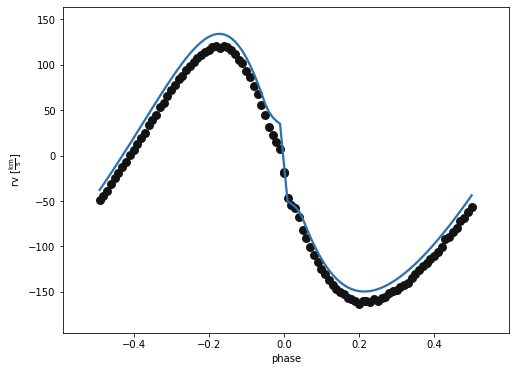

In [12]:
b.flip_constraint('asini@primary', solve_for='sma@binary')
b.adopt_solution('rvgeom_solution')

b.run_compute()
_ = b.plot(x='phases', show=True)

As can be expected, the resulting model RV is not as close to the data as in the case of two RVs because of the lack of information to properly analytically estimate some of the key parameters.